<h1>Описание проекта</h1>

У нас есть исторические данные о заказах такси в аэропортах. Нужно спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Построим модель для предсказания количества заказов такси на следубщий час.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span><ul class="toc-item"><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Остаток-декомпозиции" data-toc-modified-id="Остаток-декомпозиции-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Остаток декомпозиции</a></span></li></ul></li><li><span><a href="#Создание-стационарного-ряда" data-toc-modified-id="Создание-стационарного-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Создание стационарного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков,-разделение-на-выборки" data-toc-modified-id="Создание-признаков,-разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков, разделение на выборки</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

In [1]:
#загрузка библиотек
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
#загрузка данных
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#сортировали по индексу(времени)
data.sort_index(inplace=True)

In [4]:
#ресемплирование
data = data.resample('1H').sum()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
#првоерка пропусков
data.isnull().sum()

num_orders    0
dtype: int64

**Вывод:**
Мы загрузили данные преобразовали их в нужный формат и индексировали даты. Затем провели ресемплирование по одному часу.

## Анализ

In [7]:
decomposed = seasonal_decompose(data)

### Скользящее среднее

Нам даны исторические данные о заказах такси в аэропортах с 1го марта, по 31 августа.

In [8]:
#добавим moving average и скользящее стандартное отклонение
data['rolling_mean'] = data['num_orders'].rolling(25).mean()
data['std'] = data['num_orders'].rolling(25).std()

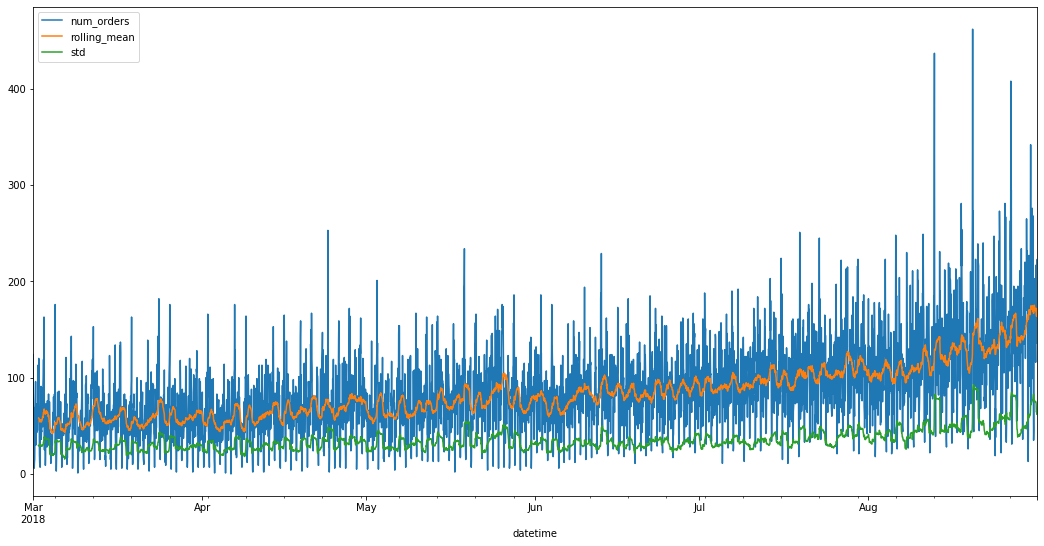

In [9]:
#построим график
data.plot(figsize=(18, 9));

По графику можно предположить, что заказы такси в аэропорт постепенно увеличиваются, а в августе делают сильный скачёк.

Данное распределение мы можем назвать **нестационарным**, потому что меняются и средняя скользящая и скользящее стандартное отклонение.

### Тренды и сезонность

`Тренд` — плавное изменение среднего значения ряда без повторяющихся закономерностей. 

`Сезонность` — циклично повторяющиеся закономерности во временном ряду.

#### Тренд

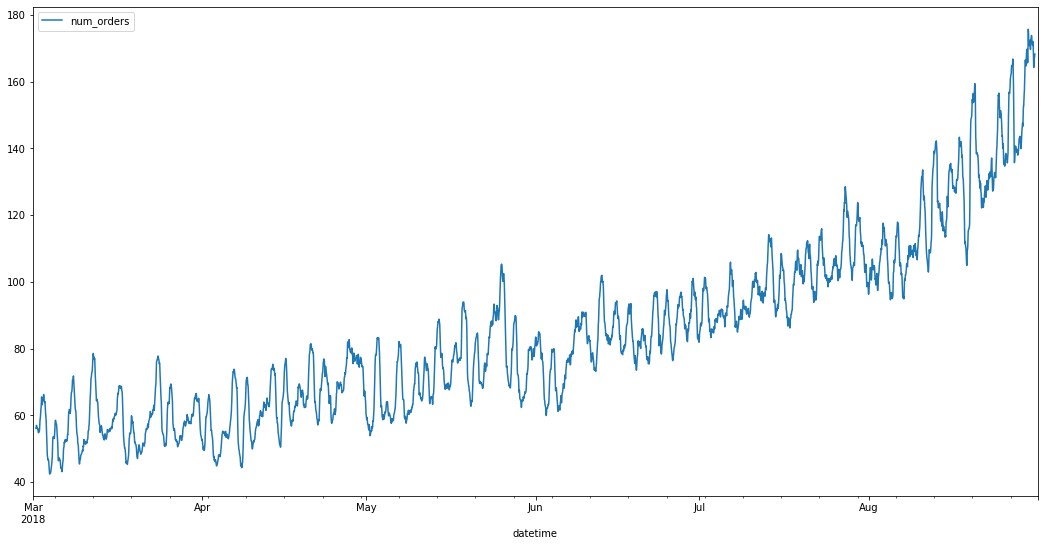

In [10]:
decomposed.trend.plot(figsize=(18, 9));

С помощью тренда мы видим, что  с середины апреля начинается увеличение заказов такси.

#### Сезонность

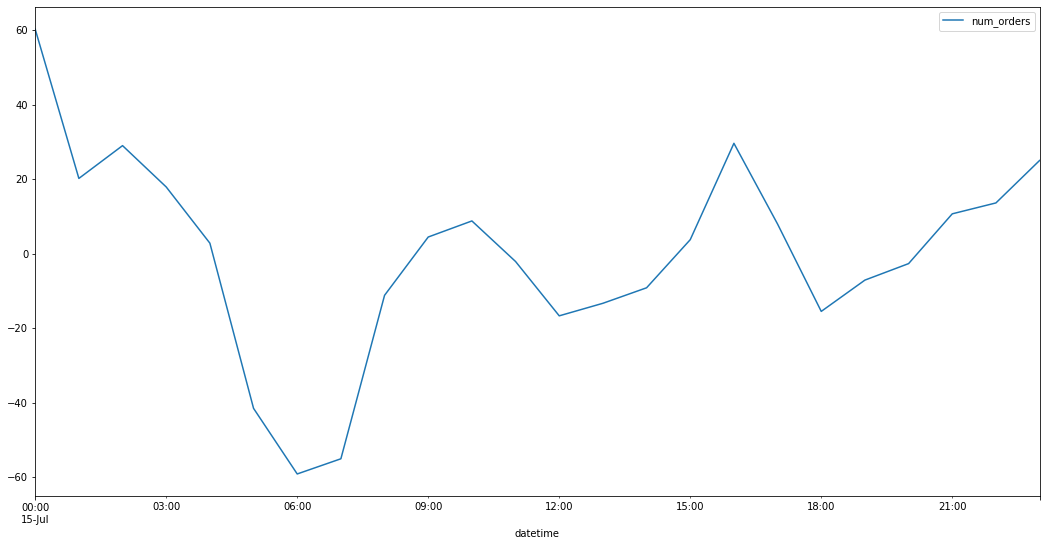

In [11]:
decomposed.seasonal['2018-07-15':'2018-07-15'].plot(figsize=(18, 9));

#### Остаток декомпозиции

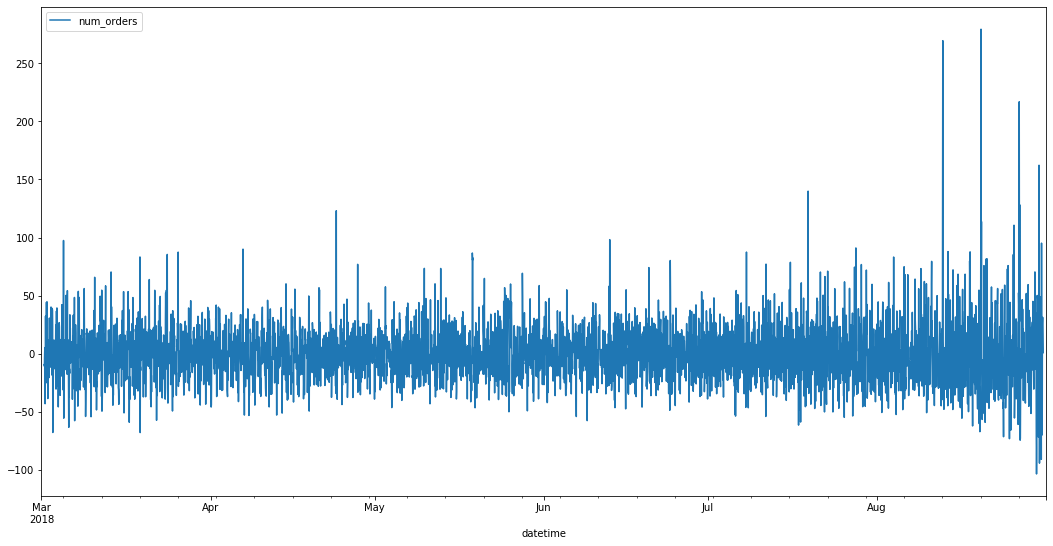

In [12]:
decomposed.resid.plot(figsize=(18, 9));

**Вывод:**

Получившийся восходящий тренд по месяцам к августу на данном отрезке времени является лишь ростом количества клиентов компании, а не сезонным явлением. 

### Создание стационарного ряда
    

Стохастический процесс стационарный, если его распределение со временем не меняется.

Стационарные ряды легче предсказывать, поэтому сделаем наши данные стационарным рядом.

In [13]:
#data = data - data.shift()

In [14]:
#data.plot(figsize=(18, 9));

Средние перестали менятся. Значит мы получили стационарный ряд.\
Я закомментирую данный пунк что бы получить более понятный график в конце.

## Обучение

### Создание признаков, разделение на выборки

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(data, 21, 25)

In [17]:
random_state = 999
data = data.dropna()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('num_orders', axis=1), data['num_orders'], test_size=0.10, random_state=random_state, shuffle=False)

### LinearRegression

In [19]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_pred_lr = model_lr.predict(X_train)

In [20]:
print("RMSE обучающей выборки:", mean_squared_error(y_train, train_pred_lr)**0.5)

RMSE обучающей выборки: 26.854029665176345


### LGBMRegressor

In [21]:
%%time
model_lg = LGBMRegressor(random_state=random_state, max_depth = 15, num_leaves = 160)
model_lg.fit(X_train, y_train)

Wall time: 296 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=160, objective=None,
              random_state=999, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
train_pred_lg = model_lg.predict(X_train)

In [23]:
print("RMSE обучающей выборки:", mean_squared_error(y_train, train_pred_lg)**0.5)

RMSE обучающей выборки: 6.736692884753103


_______________________________________________________________________________________________________________________________
Модели готовы осталось провести тестирование.
_______________________________________________________________________________________________________________________________

### Тестирование

In [24]:
#предсказания наших моделей
test_pred_lr = model_lr.predict(X_test)
test_pred_lg = model_lg.predict(X_test)

In [25]:
print("RMSE тестовой выборки LinearRegression:", mean_squared_error(y_test, test_pred_lr)**0.5)
print("RMSE тестовой выборки LGBMRegressor:", mean_squared_error(y_test, test_pred_lg)**0.5)

RMSE тестовой выборки LinearRegression: 44.77795192629348
RMSE тестовой выборки LGBMRegressor: 42.60890358531632


In [26]:
# к предсказаниям добавим действующие индексы
test_pred_lg = pd.Series(test_pred_lg, index = y_test.index)

**Сравним предсказания модели и дейсвтвительные значения на графике**

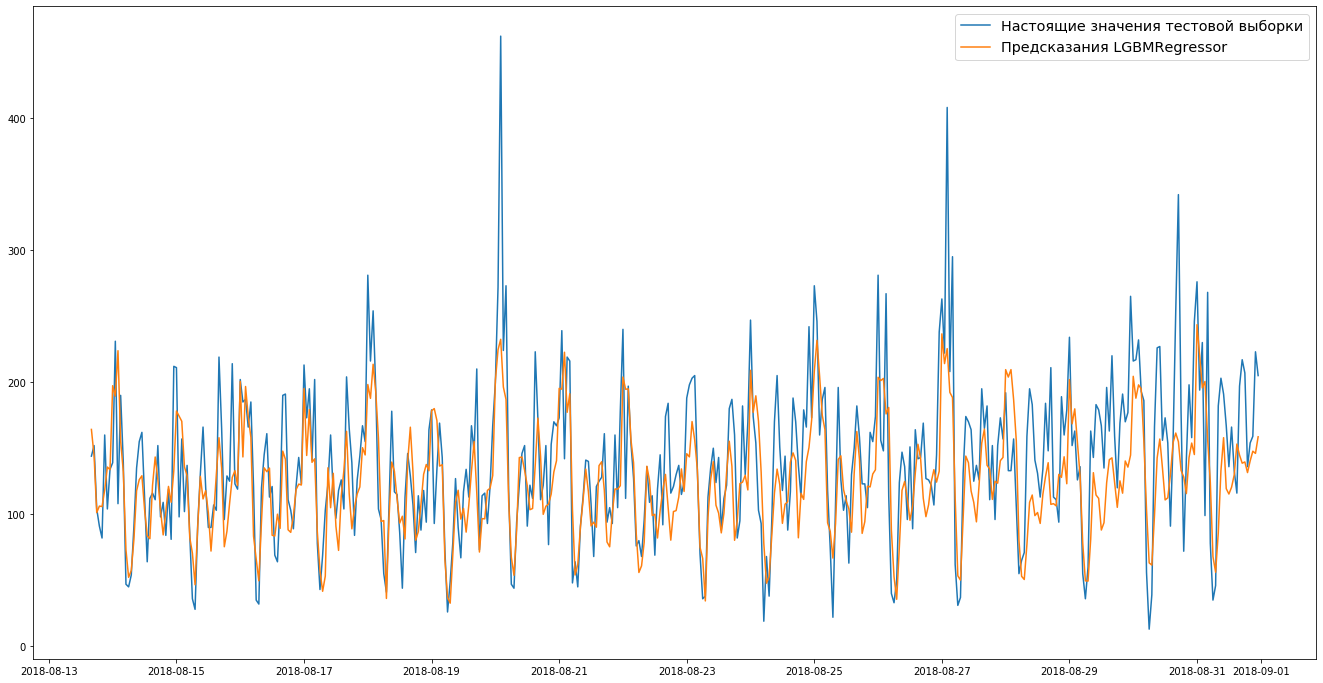

In [27]:
plt.figure(figsize=(23, 12))
plt.plot(y_test)
plt.plot(test_pred_lg)
plt.legend(['Настоящие значения тестовой выборки', 'Предсказания LGBMRegressor'], fontsize ='x-large')
plt.show()

## Общий вывод

Решить задачу получилось, *rmse* подходит для выполнения тз, но есть некоторые моменты:

Модель предсказывает, но выбросы всё равно сильно выделяются;\
Возможно вместо ML модели проще использовать просто скользящую среднюю, которая на таком количестве данных будет работать не сильно хуже;\
Данные за больший период позволят нам выделить сезонность по месяцам с отделением от роста клиентов самого бизнеса и сделать модель лучше.